<a href="https://colab.research.google.com/github/Prathyusha-Akundi/Skin-Classification/blob/main/No_multiscale_featurewiseNorm_ISIC17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D 
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import *
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import Model


filterwarnings('ignore')
np.random.seed(101)
EFNS = [EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, 
        EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_path = '/content/drive/MyDrive/ISIC_2017/'
TRAIN_IMAGE_DIR = root_path+'ISIC-2017_Training_Data'
VAL_IMAGE_DIR = root_path+'ISIC-2017_Validation_Data/ISIC-2017_Validation_Data'
train_panda_path = os.path.join(root_path, 'ISIC-2017_Training_Part3_GroundTruth.csv')
val_panda_path = os.path.join(root_path, 'ISIC-2017_Validation_Part3_GroundTruth.csv')
print(len(os.listdir(TRAIN_IMAGE_DIR)), len(os.listdir(VAL_IMAGE_DIR)))
#os.path.join

4001 301


In [4]:
def preprocess(df):
    for index, img in enumerate(df['image_id']):
        img = img+'.jpg'
        df['image_id'][index]=img
    # df.drop(['UNK'], axis=1, inplace=True)

In [5]:
def train_test_split(df, test_ratio=0.2):
    test_rows = (np.random.rand(int(test_ratio*df.shape[0]))*df.shape[0]).astype(int)
    test_df =  df.iloc[test_rows]
    test_df = test_df.reset_index().drop(['index'], axis=1)
    df.drop(test_rows, axis=0, inplace=True)
    df = df.reset_index().drop(['index'], axis=1)
    test_df = test_df.reset_index().drop(['index'], axis=1)
    df = df.reset_index().drop(['index'], axis=1)

    return df,  test_df

In [6]:
full_df = pd.read_csv(train_panda_path)
full_df.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0


In [7]:
val_df = pd.read_csv(val_panda_path)
preprocess(full_df)
preprocess(val_df)
train_df, test_df = train_test_split(full_df)
labels=list(train_df.columns[1:])
print(labels)
train_df.head()

['melanoma', 'seborrheic_keratosis']


,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000.jpg,0.0,0.0
1,ISIC_0000001.jpg,0.0,0.0
2,ISIC_0000003.jpg,0.0,0.0
3,ISIC_0000004.jpg,1.0,0.0
4,ISIC_0000006.jpg,0.0,0.0


In [8]:
def get_segmentation_model(weights_path, inputs=None):
  # Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
  INPUT_CHANNELS = 3
  # Number of output masks (1 in case you predict only one type of objects)
  OUTPUT_MASK_CHANNELS = 1
  # Pretrained weights
  def double_conv_layer(x, size, dropout=0.40, batch_norm=True, name = None):
    
    axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same',name=name)(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

  dropout_val=0.50
    
  if inputs is None:  
    inputs = Input((256, 256, INPUT_CHANNELS))
  axis = 3
  filters = 32

  conv_256 = double_conv_layer(inputs, filters)
  pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_256)

  conv_112 = double_conv_layer(pool_112, 2*filters)
  pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

  conv_56 = double_conv_layer(pool_56, 4*filters)
  pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

  conv_28 = double_conv_layer(pool_28, 8*filters)
  pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

  conv_14 = double_conv_layer(pool_14, 16*filters)
  pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

  conv_7 = double_conv_layer(pool_7, 32*filters, name='features')

  up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
  up_conv_14 = double_conv_layer(up_14, 16*filters)

  up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
  up_conv_28 = double_conv_layer(up_28, 8*filters)

  up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
  up_conv_56 = double_conv_layer(up_56, 4*filters)

  up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
  up_conv_112 = double_conv_layer(up_112, 2*filters)

  up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_256], axis=axis)
  up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

  conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
  conv_final = Activation('sigmoid')(conv_final)
  pred = Reshape((256,256))(conv_final)
  model = Model(inputs, pred, name="UNET_256")
  model.load_weights(weights_path)
  return model

In [9]:
segmentation_weights = '/content/drive/MyDrive/Upwork/Skin Classification/segmentation_weights/segmentation_256_unet_final'
segmentator = get_segmentation_model(weights_path=segmentation_weights)
segmentator.trainable = False

In [10]:
target_w = 256
target_h = 256

def crop_mask_prep(im):
    im = np.reshape(im,(1,target_w,target_h,3))
    im = im*(1./255)
    mask = segmentator.predict(im)
    im = np.squeeze(im)
    mask = np.squeeze(mask)
    mask_ = np.dstack((mask,mask,mask))
    mask_ = np.uint8(mask_*255)
    try:
        maskgray = cv2.cvtColor(mask_,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(maskgray,127,255,cv2.THRESH_BINARY)
        # find contours 
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        areas = [cv2.contourArea(contour) for contour in contours]
        cnt = contours[np.argmax(areas)]
        # straight rectangle
        x,y,w,h = cv2.boundingRect(cnt)
        final = im[y:y+h, x:x+w]
        final = cv2.resize(final, (target_w,target_h))
        final = np.uint8(final*255)
    except:
        final = np.uint8(im*255)

    
    return final

In [11]:
def get_generator(df=train_df, image_dir=TRAIN_IMAGE_DIR, x_col='image_id', y_cols=labels, shuffle=True, batch_size=32, seed=42, target_w = 256, target_h = 256):
    
    
    print("getting  generator...") 
    # normalize images
    image_generator1 = ImageDataGenerator(
        # rescale=1./255,  
        featurewise_center = True,
        featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        # rotation_range = 15,
#         preprocessing_function = preprocessing
        # samplewise_center=True,
        # samplewise_std_normalization= True
        )
    
    # flow from directory with specified batch size
    # and target image size
    generator1 = image_generator1.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator1

In [12]:
batch_size = 32
train_generator = get_generator(df = train_df, batch_size = batch_size)
valid_generator = get_generator(df = val_df,image_dir=VAL_IMAGE_DIR, batch_size = batch_size)
test_generator = get_generator(df = test_df, batch_size = batch_size)

getting  generator...
Found 1634 validated image filenames.
getting  generator...
Found 150 validated image filenames.
getting  generator...
Found 400 validated image filenames.


In [13]:
class_labels = train_df[labels].values
class_labels.shape

(1634, 2)

In [14]:
def compute_class_freqs(labels):

    N = labels.shape[0]
    
    positive_frequencies = np.mean(labels, axis=0)
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [15]:
freq_pos, freq_neg = compute_class_freqs(class_labels)

pos_weights = freq_neg
neg_weights = freq_pos

In [16]:
pos_weights

array([0.8127295 , 0.87637699])

In [17]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        
        # initialize loss to zero
        
        y_true = tf.cast(y_true, tf.float32)
        

        
            # for each class, add average weighted loss for that class 
        loss = K.mean(-(pos_weights*y_true*K.log(y_pred+epsilon)
                          + neg_weights*(1-y_true)*K.log((1-y_pred)+epsilon)))
        return loss
    
    return weighted_loss

In [18]:
x,y = next(train_generator)

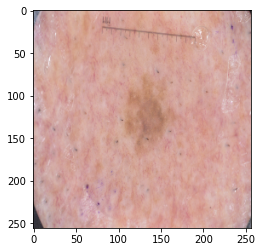

In [19]:
i = 8
plt.imshow(np.uint8(x[i]))


In [21]:
np.max(x[i])

188.0

In [22]:
x, y = next(valid_generator)


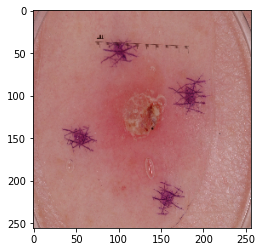

In [23]:
i = 8
plt.imshow(np.uint8(x[i]))


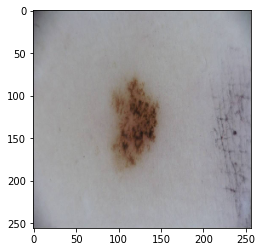

In [24]:
x, y = next(test_generator)

i = 8
plt.imshow(np.uint8(x[i]))


In [20]:
def get_classifier_model(labels,dim = 256, ef = 0):
    ### Base Model ###
    # Input
    
    input1 = Input(shape = (dim, dim, 3))
    
    # Base EfficientNet pretrained model
    base = EFNS[ef](
        input_shape = (dim, dim, 3),
        weights = "imagenet",
        include_top = False,
        # pooling = 'avg'
    )
    x1 = base(input1)    
    x1 = Conv2D(512, (3, 3), padding='same',name='effnet_features1', activation = "relu")(x1)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
    
    x = Dense(128, activation = "relu")(x1)
   
  
    ### Rebuild top ###
    x = Dense(labels, activation = "sigmoid")(x)


    model = Model(inputs = input1, outputs = x)
    model.compile(optimizer= 'adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=[tf.keras.metrics.AUC(from_logits=False)])
   
    return model

In [21]:
model = get_classifier_model(len(labels))

16719872/16705208 [==============================] - 0s 0us/step


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 effnet_features1 (Conv2D)   (None, 8, 8, 512)         5898752   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                             

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3, verbose=1)
checkpoint_filepath = '/content/drive/MyDrive/Upwork/Skin Classification/models/no_multiscale_B0_2017'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    verbose = 1,
    save_best_only=True)

In [24]:
STEP_SIZE_TRAIN=len(train_df)//batch_size
STEP_SIZE_VALID= len(val_df)//batch_size
STEP_SIZE_TEST=len(test_df)//batch_size
history = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,verbose=1, 
                        validation_steps=STEP_SIZE_VALID, epochs=25, callbacks=[callback, model_checkpoint_callback])

Epoch 1/25
51/51 [==============================] - ETA: 0s - loss: 0.1603 - auc: 0.7605 
Epoch 00001: val_auc improved from -inf to 0.67588, saving model to /content/drive/MyDrive/Upwork/Skin Classification/models/no_multiscale_B0_2017
51/51 [==============================] - 1669s 32s/step - loss: 0.1603 - auc: 0.7605 - val_loss: 0.4532 - val_auc: 0.6759
Epoch 2/25
51/51 [==============================] - ETA: 0s - loss: 0.1358 - auc: 0.8304
Epoch 00002: val_auc improved from 0.67588 to 0.69220, saving model to /content/drive/MyDrive/Upwork/Skin Classification/models/no_multiscale_B0_2017
51/51 [==============================] - 249s 5s/step - loss: 0.1358 - auc: 0.8304 - val_loss: 0.4059 - val_auc: 0.6922
Epoch 3/25
51/51 [==============================] - ETA: 0s - loss: 0.1127 - auc: 0.8897
Epoch 00003: val_auc improved from 0.69220 to 0.75292, saving model to /content/drive/MyDrive/Upwork/Skin Classification/models/no_multiscale_B0_2017
51/51 [==============================] - 24

In [25]:
model.load_weights(checkpoint_filepath)

In [26]:
loss, val_auc = model.evaluate(valid_generator)
print(val_auc)

5/5 [==============================] - 33s 6s/step - loss: 0.2742 - auc: 0.8929
0.8929093480110168


In [27]:
test_loss, test_auc = model.evaluate(test_generator)
print(test_auc)

13/13 [==============================] - 309s 25s/step - loss: 0.2655 - auc: 0.8565
0.8564947247505188


In [ ]:
# # from tensorflow.keras.preprocessing import image
# # from sklearn.metrics import roc_auc_score, roc_curve
# # from tensorflow.compat.v1.logging import INFO, set_verbosity
# # import cv2

# from keras.preprocessing import image
# from sklearn.metrics import roc_auc_score, roc_curve
# from tensorflow.compat.v1.logging import INFO, set_verbosity
# import cv2

# def get_roc_curve(labels, predicted_vals, generator):
#     auc_roc_vals = []
#     for i in range(len(labels)):
#         try:
#             gt = generator.labels[:, i]
#             pred = predicted_vals[:, i]
#             auc_roc = roc_auc_score(gt, pred)
#             auc_roc_vals.append(auc_roc)
#             fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
#             plt.figure(1, figsize=(10, 10))
#             plt.plot([0, 1], [0, 1], 'k--')
#             plt.plot(fpr_rf, tpr_rf,
#                      label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
#             plt.xlabel('False positive rate')
#             plt.ylabel('True positive rate')
#             plt.title('ROC curve')
#             plt.legend(loc='best')
#         except:
#             print(
#                 f"Error in generating ROC curve for {labels[i]}. "
#                 f"Dataset lacks enough examples."
#             )
#     plt.show()
#     return auc_roc_vals

# def get_accuracy(generator, predicted_vals):
#   acc = np.zeros(len(labels))
#   for i in range(len(labels)):
#     pred = np.int32(predicted_vals[:,i]>0.5)
#     gt = generator.labels[:, i]
#     acc[i] = np.sum(pred==gt)/len(pred)
#   return acc

In [ ]:
# from tqdm import tqdm
# def get_predictions(generator, steps):
#     preds = []
#     gt = []
#     cnt = 0
#     for data, th in tqdm(generator):
#         preds.extend(model.predict(data))
#         gt.extend(th)
#         cnt += 1
#         if(cnt>= steps):
#             break
#     return preds, gt

In [ ]:
# predicted_vals = model.predict_generator(valid_generator, steps = len(valid_generator), verbose =1)

In [ ]:
# auc_rocs = get_roc_curve(labels, predicted_vals, valid_generator)

In [ ]:
# print([labels[i]+" : {0}".format(round(auc_rocs[i],3)) for i in range(len(labels))])
# print('Mean AUC: {0}'.format(np.mean(auc_rocs)))

In [ ]:
# val_acc = get_accuracy(valid_generator, predicted_vals)
# print([labels[i]+" : {0}".format(round(val_acc[i],3)) for i in range(len(labels))])
# print('Mean ACC: {0}'.format(np.mean(val_acc)))

In [ ]:
# predicted_test = model.predict_generator(test_generator, steps = len(test_generator), verbose=1)

In [ ]:
# auc_rocs_test = get_roc_curve(labels, predicted_test, test_generator)

In [ ]:
# print([labels[i]+" : {0}".format(round(auc_rocs_test[i],3)) for i in range(len(labels))])
# print('Mean AUC: {0}'.format(np.mean(auc_rocs_test)))

In [ ]:
# test_acc = get_accuracy(test_generator, predicted_test)

In [ ]:
# print([labels[i]+" : {0}".format(round(test_acc[i],3)) for i in range(len(labels))])
# print('Mean ACC: {0}'.format(np.mean(test_acc)))